# Graph-based image segmentation
---

This notebook presents a usage example of the classes:
* `segmentation.GraphBasedSegmentation()`: implements the graph-based segmentation algorithm proposed by Felzenszwalb et. al. ([paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf)).
* `segmentation.DisjointSetForest()`: the data-structure used by the algorithm (not really used outside the other class).

## Description of the algorithm

Let's consider a grayscale image of size `NxM`, being N the height of the image and M its width. Each pixel of the image has a value between 0 and 255.

The algorithm treats each pixel as a node of a graph `G = (V,E)` where:
- `V` is the set of vertices
- `E` the set of edges (i.e. connections between a pair of nodes).

Each edge has an associated weight which - in the case of this implementation - is the *intensity distance* between the considered pair of nodes.

The pixels are connected in a 8-grid fashion: this means that each pixel is connected to its 8 neighbors.

We start by considering each node of the graph as a singleton component (at the beginning we have `height * width` components) and we merge them is an agglomerative way according to the so called *boundary evidence*.

That is: at each step of the algorithm, two components are compared and, if a boundary evidence is present, they are keep separated, otherwise they are merged into one single components. Doing so, we can reduce the number of components step-by-step reaching a final result in which each component represents a logic instance in the image.

The boundary evidence is defined as the inequality between two quantities:
- `Dif(C1, C2)`: represents the within-difference between the two components `C1` and `C2`
- `MInt(C1, C2)`: represents the inter-component difference

For more details see the [paper](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf).

For our purpose it is important to notice that the threshold depends on a parameter `k` which can be considered as a *tuning* parameter:
- larger `k`: preference for larger components
- smaller `k`: preference for smaller components

### Disjoint-set forest

The components are well represented using the *disjoint-set forest* data structure:
- it stores a collection of disjoint non-overlapping sets (or a partition of a set into disjoint subsets).
- provides operations for:
    - adding new sets
    - merging sets (replacing them by their union) 
    - find a representative member of a set. 


It works as follows:
- the set is initialized with `N * M` nodes, each of one is initially considered as a single components (or subset)
- each component has a representative/parent which is the one having greater rank
- when two components are merged into a single one, the one having greater rank is considered the parent of the other
- the size of a component indicats the number of nodes inside it


### Graph

The implementation of the `GraphBasedSegmentation` class is useful to convert an input image into a graph which can be exploited to run the graph-based segmentation algorithm.

The class provides the following methods:
- `_preprocessing()`: converts an input RGB image to a grayscale Numpy array and apply some preprocessing operations.
- `_get_diff(pixel1, pixel2)`: returns the difference in terms of intensity between the given pixels.
- `_create_edge(pixel1, pixel2)`: creates the edge between two pixels of the input image.
- `_threshold(k, size)`: defines the threshold for a component havig size = size with the constant k (`t = k/size`).
- `build_graph()`: builds the graph (list of tuples) from the input image, adding the necessary edges.
- `sort()`: sorts the graph according to the weights of the edges (non-decreasing order).
- `segment(k, min_size)`: segments the image applying the algorithm and removes the component with `size < min_size`.
- `generate_image()`: generates the segmented image.
- `find_boundaries()`: found the boundaries of the regions of the segmented image.
- `draw_boxes()`: draw rectangular boxes around each region.

In [1]:
import segmentation as seg

We can import the module in which the classes are implemented and use them in the following way:
* we create an instance of the class passing it the input image, call it `ig` (_in the example below we have an array of instances_)
* we segment the image adjusting the `k` and `min_size` parameters along with some preprocessing operation
* after the segmentation we can generate the output image (having different colors for each segmented region)
* we can also draw boxes around the found regions

In [2]:
import os

directory = '../img/input/'
images = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        images.append(os.path.join(directory, filename))
    else:
        continue

igs = [None] * len(images)
for i in range(len(images)):
    print("\nImage {}\n".format(i))
    igs[i] = seg.GraphBasedSegmentation(images[i])
    igs[i].segment(k=4000, min_size=100, preprocessing=True, contrast=1.5, gaussian_blur=2.3)
    igs[i].generate_image()
    igs[i].draw_boxes()


Image 0

Building graph...
Graph built in 0.598s.

Segmenting...
Segmentation done in 0.853s.

Removing componentes having size less than 100...
Removed components in 0.266s.

Defining regions...
Regions defined in 0.033s.

Generating image...
Image generated in 0.108s.

Searching boundaries...
Boundaries found in 0.64s.

Drawing boxes...
Boxes drawn in 0.000421s.


Image 1

Building graph...
Graph built in 0.531s.

Segmenting...
Segmentation done in 0.857s.

Removing componentes having size less than 100...
Removed components in 0.25s.

Defining regions...
Regions defined in 0.0187s.

Generating image...
Image generated in 0.126s.

Searching boundaries...
Boundaries found in 0.634s.

Drawing boxes...
Boxes drawn in 9.87e-05s.


Image 2

Building graph...
Graph built in 0.549s.

Segmenting...
Segmentation done in 0.919s.

Removing componentes having size less than 100...
Removed components in 0.274s.

Defining regions...
Regions defined in 0.0205s.

Generating image...
Image generated

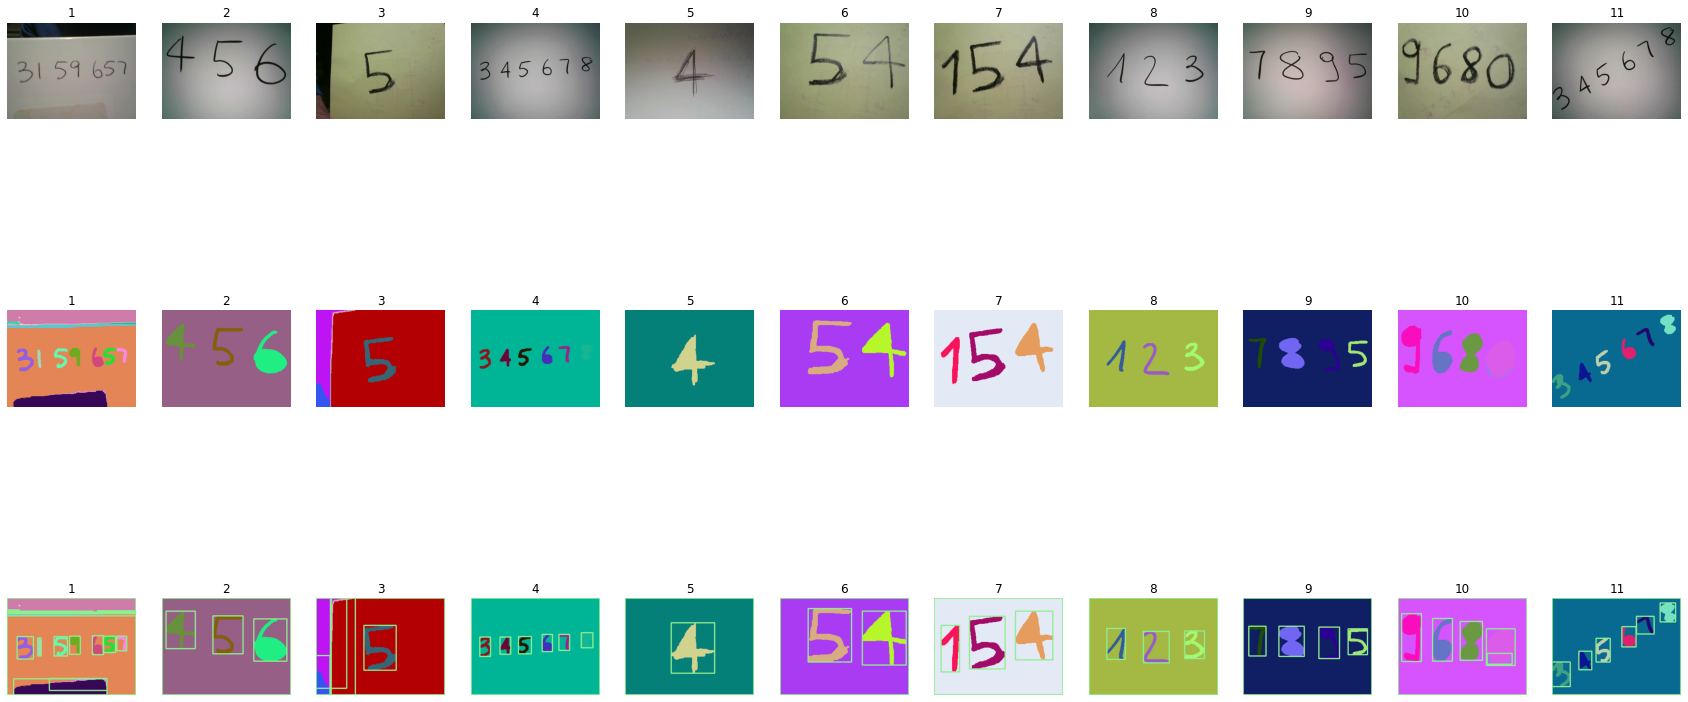

In [3]:
import matplotlib.pyplot as plt

n_images = len(images)

fig = plt.figure(figsize=(30,15))
for i in range(n_images):
    # original
    image = igs[i].img
    label = i + 1
    sp = fig.add_subplot(3, n_images, i+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
    # segmented
    image = igs[i].segmented_img
    label = i + 1
    sp = fig.add_subplot(3, n_images, i+1*n_images+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
    # boxed
    image = igs[i].boxed_img
    label = i + 1
    sp = fig.add_subplot(3, n_images, i+2*n_images+1)
    sp.set_title(label)
    plt.axis('off')
    plt.imshow(image)
plt.show()